<a href="https://colab.research.google.com/github/ortalby/086761/blob/master/Implicit_GON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# requirements
import torch
import torch.nn as nn
import torchvision
import numpy as np

# colab requirements
from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep

In [ ]:
# image data
dataset_name = 'fashion' # ['mnist', 'fashion']
img_size = 28
n_channels = 1
img_coords = 2

# training info
lr = 1e-4
batch_size = 64
num_latent = 32
hidden_features = 256
num_layers = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# create the GON network (a SIREN as in https://vsitzmann.github.io/siren/)
class SirenLayer(nn.Module):
    def __init__(self, in_f, out_f, w0=30, is_first=False, is_last=False):
        super().__init__()
        self.in_f = in_f
        self.w0 = w0
        self.linear = nn.Linear(in_f, out_f)
        self.is_first = is_first
        self.is_last = is_last
        self.init_weights()
    
    def init_weights(self):
        b = 1 / self.in_f if self.is_first else np.sqrt(6 / self.in_f) / self.w0
        with torch.no_grad():
            self.linear.weight.uniform_(-b, b)

    def forward(self, x):
        x = self.linear(x)
        return x if self.is_last else torch.sin(self.w0 * x)

def gon_model(dimensions):
    first_layer = SirenLayer(dimensions[0], dimensions[1], is_first=True)
    other_layers = []
    for dim0, dim1 in zip(dimensions[1:-2], dimensions[2:-1]):
        other_layers.append(SirenLayer(dim0, dim1))
    final_layer = SirenLayer(dimensions[-2], dimensions[-1], is_last=True)
    return nn.Sequential(first_layer, *other_layers, final_layer)

In [ ]:
# helper functions
def get_mgrid(sidelen, dim=2):
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def slerp(a, b, t):
    omega = torch.acos((a/torch.norm(a, dim=1, keepdim=True)*b/torch.norm(b, dim=1, keepdim=True)).sum(1)).unsqueeze(1)
    res = (torch.sin((1.0-t)*omega)/torch.sin(omega))*a + (torch.sin(t*omega)/torch.sin(omega)) * b
    return res

def slerp_batch(model, z, coords):
    lz = z.data.clone().squeeze(1)
    col_size = int(np.sqrt(z.size(0)))
    src_z = lz.data[:col_size].repeat(col_size,1)
    z1, z2 = lz.data.split(lz.shape[0]//2)
    tgt_z = torch.cat([z2, z1])
    tgt_z = tgt_z[:col_size].repeat(col_size,1)
    t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).contiguous().view(batch_size,1).contiguous().to(device)
    z_slerp = slerp(src_z, tgt_z, t)
    z_slerp_rep = z_slerp.unsqueeze(1).repeat(1,coords.size(1),1) 
    g_slerp = model(torch.cat((coords, z_slerp_rep), dim=-1))
    return g_slerp

def gon_sample(model, recent_zs, coords):
    zs = torch.cat(recent_zs, dim=0).squeeze(1).cpu().numpy()
    mean = np.mean(zs, axis=0)
    cov = np.cov(zs.T)
    sample = np.random.multivariate_normal(mean, cov, size=batch_size)
    sample = torch.tensor(sample).unsqueeze(1).repeat(1,coords.size(1),1).to(device).float()
    model_input = torch.cat((coords, sample), dim=-1)
    return model(model_input)

In [ ]:
# load datasets
if dataset_name == 'mnist':
    dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ]))
if dataset_name == 'fashion':
    dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ]))

train_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
train_iterator = iter(cycle(train_loader))

In [ ]:
# define GON architecture, for example gon_shape = [34, 256, 256, 256, 256, 1]
gon_shape = [img_coords+num_latent] + [hidden_features]*num_layers + [n_channels]
F = gon_model(gon_shape).to(device)

optim = torch.optim.Adam(lr=lr, params=F.parameters())
c = torch.stack([get_mgrid(img_size, 2) for _ in range(batch_size)]).to(device) # coordinates
recent_zs = []
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(F.parameters()))}')

> Number of parameters 206593


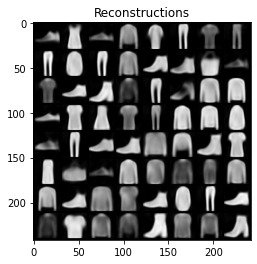

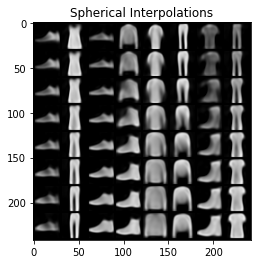

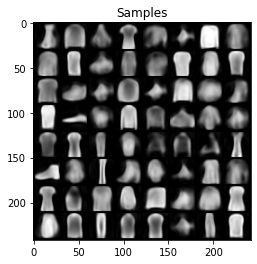

In [ ]:
for step in range(501):
    # sample a batch of data
    x, t = next(train_iterator)
    x, t = x.to(device), t.to(device)
    x = x.permute(0, 2, 3, 1).reshape(batch_size, -1, n_channels)

    # compute the gradients of the inner loss with respect to zeros (gradient origin)
    z = torch.zeros(batch_size, 1, num_latent).to(device).requires_grad_()
    z_rep = z.repeat(1,c.size(1),1)
    g = F(torch.cat((c, z_rep), dim=-1))
    L_inner = ((g - x)**2).sum(1).mean()
    z = -torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]

    # now with z as our new latent points, optimise the data fitting loss
    z_rep = z.repeat(1, c.size(1), 1)
    g = F(torch.cat((c, z_rep), dim=-1))
    L_outer = ((g - x)**2).sum(1).mean()
    optim.zero_grad()
    L_outer.backward()
    optim.step()

    # compute sampling statistics
    recent_zs.append(z.detach())
    recent_zs = recent_zs[-100:]

    if step % 100 == 0 and step > 0:
        print(f"Step: {step}   Loss: {L_outer.item():.3f}")

        # plot reconstructions, interpolations, and samples
        recons = torchvision.utils.make_grid(torch.clamp(g, 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), nrow=8)
        slerps = torchvision.utils.make_grid(torch.clamp(slerp_batch(F, z.data, c), 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), nrow=8)
        sample = torchvision.utils.make_grid(torch.clamp(gon_sample(F, recent_zs, c), 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size))

        clear_output()
        plt.title('Reconstructions')
        plt.imshow(recons[0,:,:].reshape(242,242,1).repeat(1,1,3).cpu().data.numpy())
        plt.figure()
        plt.title('Spherical Interpolations')
        plt.imshow(slerps[0,:,:].reshape(242,242,1).repeat(1,1,3).cpu().data.numpy())
        plt.figure()
        plt.title('Samples')
        plt.imshow(sample[0,:,:].reshape(242,242,1).repeat(1,1,3).cpu().data.numpy())
        plt.show()
        sleep(1)

**Comments:**

The implicit gradient origin network loss is:

$$G_{\mathbf{x}} = \int \mathcal{L} \Big( \Phi_{\mathbf{x}}(\mathbf{c}), F\Big(\mathbf{c} \oplus -\nabla_{\mathbf{z}_0} \int \mathcal{L} \big( \Phi_{\mathbf{x}}(\mathbf{c}), F(\mathbf{c} \oplus \mathbf{z}_0) \big) \mathrm{d}\mathbf{c} \Big) \Big) \mathrm{d}\mathbf{c},$$

where we first compute the gradients of the inner loss with respect to the zero vector $\mathbf{z}_0$:
$$\mathbf{z}=-\nabla_{\mathbf{z}_0} \int \mathcal{L} \big( \Phi_{\mathbf{x}}(\mathbf{c}), F(\mathbf{c} \oplus \mathbf{z}_0) \big) \mathrm{d}\mathbf{c}.$$

```
z = torch.zeros(batch_size, 1, num_latent).to(device).requires_grad_()
z_rep = z.repeat(1,c.size(1),1)
g = F(torch.cat((c, z_rep), dim=-1))
L_inner = ((g - x)**2).sum(1).mean()
z = -torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]
```

These gradients act as the latent space that we will call $\mathbf{z}$. They are then concatenated $\oplus$ to the coordinates $\mathbf{c}$ and now we can optimise the outer loss:

$$G_{\mathbf{x}} = \int \mathcal{L} \Big( \Phi_{\mathbf{x}}(\mathbf{c}), F(\mathbf{c} \oplus \mathbf{z} ) \Big) \mathrm{d}\mathbf{c}$$

```
z_rep = z.repeat(1, c.size(1), 1)
g = F(torch.cat((c, z_rep), dim=-1))
L_outer = ((g - x)**2).sum(1).mean()
optim.zero_grad()
L_outer.backward()
optim.step()
```

When trained, we can simply sample $\mathbf{z}\sim p_z$ and query the model $F(\mathbf{c} \oplus \mathbf{z})$:

```
z_rep = z.repeat(1, c.size(1), 1)
g_sampled = F(torch.cat((c, z_rep), dim=-1))
```